# Multimodal assistant with Phi-4-multimodal and OpenVINO

Phi-4-multimodal-instruct is a lightweight open multimodal foundation model. The model processes text, image, and audio inputs, generating text outputs. Phi-4-multimodal-instruct has 5.6B parameters and is a multimodal transformer model. The model has the pretrained Phi-4-mini as the  backbone language model, and the advanced encoders and adapters of vision and speech.
In this tutorial we will explore how to run Phi-4-multimodal model using [OpenVINO](https://github.com/openvinotoolkit/openvino) and optimize it using [NNCF](https://github.com/openvinotoolkit/nncf).
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model to OpenVINO Intermediate Representation](#Convert-model-to-OpenVINO-Intermediate-Representation)
    - [Compress model weights to 4-bit](#Compress-model-weights-to-4-bit)
- [Create inference pipeline](#Create-inference-pipeline)
- [Run model inference](#Run-model-inference)
    - [Text-only input](#Text-only-input)
    - [Text-Image input](#Text-Image-input)
    - [Audio-text input](#Audio-text-input)
    - [Audio-only input](#Audio-only-input)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/phi-4-multimodal/phi-4-multimodal.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip -q install "transformers>=4.48" "torch>2.1" "torchvision" "torchaudio" soundfile Pillow "backoff" "peft==0.13.2" "gradio>=4.19" "librosa" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU --pre --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly "openvino>=2025.0.0" "nncf>=2.15"

In [2]:
import requests
from pathlib import Path

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/phi-4-multimodal/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("ov_phi4_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/phi-4-multimodal/ov_phi4_helper.py")
    open("ov_phi4_helper.py", "w").write(r.text)


if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

## Convert model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)

Phi-4-multimodal is PyTorch model. OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`. 

The script `ov_phi4_helper.py` contains helper function for model conversion, please check its content if you interested in conversion details.

<details>
  <summary><b>Click here for more detailed explanation of conversion steps</b></summary>
Phi-4-multimodal is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this <a href="https://huggingface.co/blog/how-to-generate">blog</a>. The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the  <a href="https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate">documentation</a>. To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

Phi-4-multimodal model consists of 4 parts:

* **Vision Embeddings Model** for encoding input images into embedding space.
* **Text Embeddings Model** for conversion input text tokens into embedding space.
* **Audio Embeddings Model** for encoding input audio into embedding space
* **Language Model** for generation answer based on input embeddings provided by Image Encoder and Input Embedding models.

</details>


### Compress model weights to 4-bit
[back to top ⬆️](#Table-of-contents:)


For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). 

<details>
    <summary><b>Click here for more details about weight compression</b></summary>
Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).
</details>

In [3]:
from pathlib import Path

model_id = "microsoft/phi-4-multimodal-instruct"

base_model_path = Path(model_id.split("/")[-1])

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("phi-4-multimodal.ipynb")

/home/ea/work/py311/lib/python3.11/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


In [4]:
import ipywidgets as widgets

to_compress = widgets.Checkbox(value=True, description="Compress model", disabled=False)

to_compress

Checkbox(value=True, description='Compress model')

In [5]:
from ov_phi4_helper import convert_phi4mm

# Uncomment the line to see model conversion code
# ??convert_phi4mm

2025-02-27 10:09:04.770657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 10:09:04.784203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740636544.798659 1177182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740636544.803213 1177182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 10:09:04.819369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
import nncf


if to_compress.value:
    quantization_config = {
        "vision": {"mode": nncf.CompressWeightsMode.INT8_ASYM},
        "llm": {"mode": nncf.CompressWeightsMode.INT4_SYM, "group_size": 64, "ratio": 1.0},
        "audio": {"mode": nncf.CompressWeightsMode.INT8_ASYM},
    }
    model_path = base_model_path.parent / (base_model_path.name + "-int4-ov")
else:
    quantization_config = None
    model_path = base_model_path.parent / (base_model_path.name + "-fp16-ov")


convert_phi4mm(model_id, model_path, quantization_config=quantization_config)

⌛ microsoft/phi-4-multimodal-instruct conversion started. Be patient, it may takes some time.
⌛ Load Original model


/home/ea/work/py311/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Original model successfully loaded
⌛ Convert Audio embedding model
✅ Audio embedding model successfully converted
⌛ Convert Image embedding model


/home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/phi-4-multimodal/ov_phi4_helper.py:548: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not torch.any(~patch_attention_mask):
/home/ea/work/openvino_notebooks_new_clone/openvino_notebooks/notebooks/phi-4-multimodal/ov_phi4_helper.py:480: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  width = int(math.sqrt(patch_feature.size(1)))


INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (158 / 158)            │ 100% (158 / 158)                       │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

✅ Image embedding model successfully converted
✅ Model successfully converted and can be found in phi-4-multimodal-instruct-int4-ov


## Create inference pipeline
[back to top ⬆️](#Table-of-contents:)

`OVPhiMMModelForCausalLM` class defined in `ov_phi4_helper.py` represents model inference class. It accepts path to model directory and target device for inference, like original pipeline, `OVPhiMMModelForCausalLM` has `generate` method for getting answers. Besides that, it is compatible with original model processor class for preparing input.

In [7]:
from notebook_utils import device_widget

device = device_widget(exclude=["NPU"])
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [8]:
from ov_phi4_helper import OVPhiMMModelForCausalLM

# Uncomment the line to see model class code
# ??OVPhioMMModelForCausalLM

In [9]:
from transformers import AutoProcessor, TextStreamer

processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)
ov_model = OVPhiMMModelForCausalLM(model_path, device.value)

/home/ea/work/py311/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


## Run model inference
[back to top ⬆️](#Table-of-contents:)

Let's explore model capabilities using multimodal input

### Text-only input
[back to top ⬆️](#Table-of-contents:)

In [10]:
conversation = [{"role": "user", "content": "What is the answer for 1+1? Explain it."}]
prompt = processor.tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

inputs = processor(text=prompt, images=None, return_tensors="pt")
print("Question:\nWhat is the answer for 1+1? Explain it.")
print("Answer:")

generate_ids = ov_model.generate(**inputs, max_new_tokens=50, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

Question:
What is the answer for 1+1? Explain it.
Answer:
The answer for 1+1 is 2. This is because 1+1 is a basic arithmetic problem that involves adding the number 1 to another number 1. When you add one to one, you get two as the result.


### Text-Image input
[back to top ⬆️](#Table-of-contents:)

Question:
What is unusual on this picture?


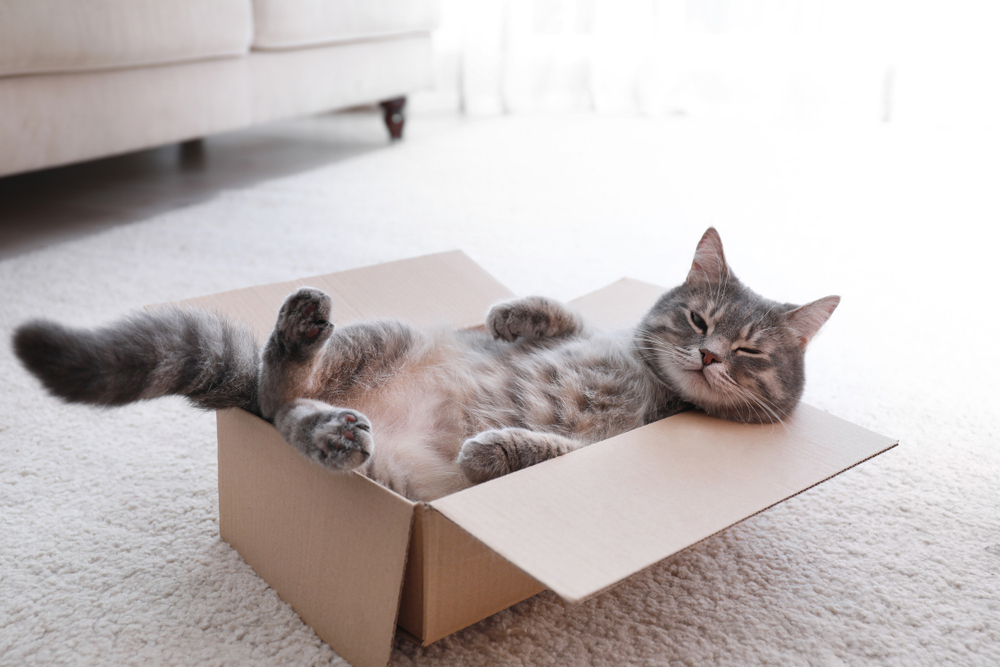

Answer:
The cat is lying in a box.


In [11]:
from ov_phi4_helper import IMAGE_SPECIAL, AUDIO_SPECIAL
import requests
from PIL import Image

image_path = Path("cat.png")

if not image_path.exists():
    url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/d5fbbd1a-d484-415c-88cb-9986625b7b11"
    image = Image.open(requests.get(url, stream=True).raw)
    image.save(image_path)
else:
    image = Image.open(image_path)

conversation = [{"role": "user", "content": f"{IMAGE_SPECIAL}What is unusual on this picture?"}]

prompt = processor.tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

inputs = processor(text=prompt, images=[image], return_tensors="pt")

print("Question:\nWhat is unusual on this picture?")
display(image)
print("Answer:")

generate_ids = ov_model.generate(**inputs, max_new_tokens=100, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

### Audio-text input
[back to top ⬆️](#Table-of-contents:)

In [12]:
import soundfile
from notebook_utils import download_file
import IPython


question = (
    "Transcribe the audio to text, and then translate the audio to  French. Use <sep> as a separator between the original transcript and the translation."
)
conversation = [{"role": "user", "content": f"{AUDIO_SPECIAL}{question}"}]
prompt = processor.tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
if not Path("Trailer.wav").exists():
    download_file("https://voiceage.com/wbsamples/in_mono/Trailer.wav", "Trailer.wav")

audio = soundfile.read("Trailer.wav")
inputs = processor(text=prompt, audios=[audio], return_tensors="pt")

print(f"Question:\n{question}")
display(IPython.display.Audio("Trailer.wav"))

print("Answer:")
generate_ids = ov_model.generate(**inputs, max_new_tokens=1000, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

Question:
Transcribe the audio to text, and then translate the audio to  French. Use <sep> as a separator between the original transcript and the translation.


Answer:
No matter what your format is, you need to keep things exciting. You want listeners to remember. <sep> Quel que soit votre format, vous devez garder les choses excitantes. Vous voulez que les auditeurs se souviennent.


### Audio-only input
[back to top ⬆️](#Table-of-contents:)

In [13]:
conversation = [{"role": "user", "content": f"{AUDIO_SPECIAL}"}]
prompt = processor.tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

if not Path("how_are_you_doing_today.wav").exists():
    download_file("https://storage.openvinotoolkit.org/models_contrib/speech/2021.2/librispeech_s5/how_are_you_doing_today.wav", "how_are_you_doing_today.wav")
audio_question = soundfile.read("how_are_you_doing_today.wav")

inputs = processor(text=prompt, audios=[audio_question], return_tensors="pt")

print("Question:")
display(IPython.display.Audio("how_are_you_doing_today.wav"))

print("Answer:")
generate_ids = ov_model.generate(**inputs, max_new_tokens=15, streamer=TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True))

Question:


Answer:
I'm doing well, thank you for asking. How about you?


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [14]:
from gradio_helper import make_demo

demo = make_demo(ov_model, processor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/